# Builders' Guide

Great open-source software has played a major role in allowing machine learning to develop at the rate that it has. Flexible, open-source software allows for rapid prototyping and the avoidance of repeitition. Just as the designers for semiconductors moved from designing individual transistors, to logical circuits to writing code, so too have machine learning practitioners moved to writing every coarser representations of the models they would like to develop. 

In the previous chapters, we have built fully-funtional deep learning models, and have leveraged open-source APIs to do this concisely, but haven't looked much under-the-hood at precisely how these APIs achieve this; this is what we will focus on in this chapter.

# Layers and Modules

Some of the first networks we consdiered were the linear models, where the model took some inputs, generated some outputs and had some (hyper-)parameters which decided how the model operated. The same basic structure of inputs, outputs, features is fairly recusively present in each individual layer, in deeper MLPs, etc. 

It is often convenient to be able to discuss models in terms of components which are larger than an individual layer, but smaller than the entire model. For example, the ResNet-152 architecture for image recognition is composed of hundreds of layers. these layers consist of repeating patterns of _groups of layers_. Similar architectures where models are composed of repeating groups of layers are common in other domains such as natural language processing and speech. 

To implement these complex neural networks, we introduce the concept of _modules_. A module may describe a single layer, a component consisting of multiple layers, or even an entire distinct model. A major benefit of this is that these sorts of modules may be combined to make more complex architectures, often recursively. 

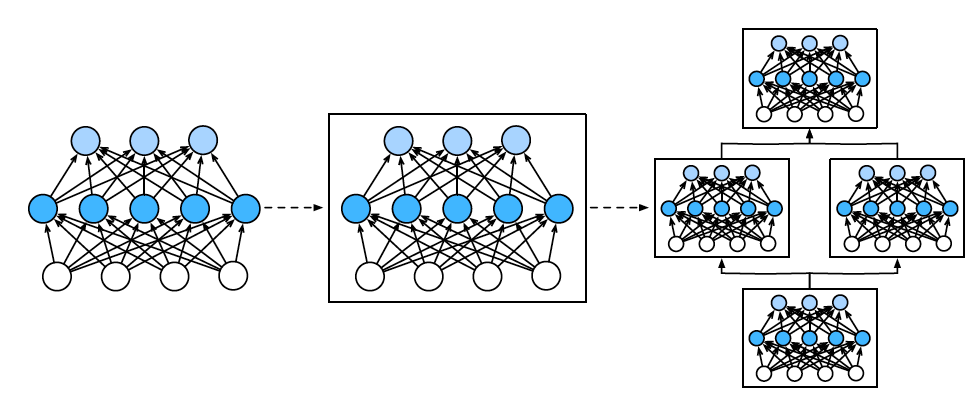


^ Multiple layers are combined into modules, which can themselves be combined to produce complex model architectures. 

From a programming standpoint, a module is represented by a class. Any subclass of a module must define a forward progagation method which transforms inputs to outputs, and must store any necessary parameters. In principle, it must also specify a backwards method, but this is in practise often taken care of for us by autograd. 

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

In [25]:
# The following code creates a network with one hidden layer and one output layer, the hidden layer has 256 units and a ReLU activation function, while the output has 10 outputs and linear activation. 

net = nn.Sequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))

X = torch.rand([2, 20])
print(f"Input shape: {X.shape=}")

print(f"Output shape: {net(X).shape=}")

Input shape: X.shape=torch.Size([2, 20])
Output shape: net(X).shape=torch.Size([2, 10])


In this example, we instantiate a module using the nn.Sequential module, which is itself a subclass of Module. This maintains an ordered list of the modules we present and connects the outputs of one linearly to the inputs of the next.

## A custom Module

Probably the easiest way to gain some intuition about the behaviour of Modules is just to implement one. A module must have the following basic functionality

1. Ingest input data as the argument to the forward() method
2. Generate an outuput by having the forward propagation return a value. The value may have a different shape to the inputs.
3. Calculate the gradient of the output with respect to the input, typically this is done automatically.
4. Store and provide access to the parameters necessary for performing the forward propagation step (I guess this just means they're not stored globally? Seems an odd thing to specify here).
5. Initialize the model parameters as needed.

In [26]:
class MLP(nn.Module):

    def __init__(self):
        # Call the parent nn.Module init function, we rely heavily on this. 
        super().__init__()
        self.hidden = nn.LazyLinear(256)
        self.out = nn.LazyLinear(10)

    def forward(self, X):
        return self.out(F.relu(self.hidden(X)))

Forward propagation method: takes X as inputs, applies relu activation and connects this to outputs, outputs logits. 

Instantiate with a call to parent `__init__` method to avoid boilerplate. 

In [27]:
net = MLP()

# I guess .shape is the shape of the inputs and outputs?
net(X).shape

torch.Size([2, 10])

This approach is extremely versatile, we can subclass to create invidual layers, whole models, and varying levels of complexity inbetween.

## The Sequential Module

Take a closer look at how the Sequential class works, designed to daisy-chain modules together. We will make a simplified version, need two key methods

1. A method for appending modules one-by-one to a list
2. A forward propagation method for passing an input through a chain of modules in the order they were specified.

In [28]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()

        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, X):
        for module in self.children():
            X = module(X)

        return X

In [29]:
net = MySequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))
net(X).shape

torch.Size([2, 10])

## Executing Code in ther Forward Propagation Method

The Sequential class is helpful for when our forward propagation method is a simple daisy chain, but not all situations are so straightforward, we may wish to execute more complicated control workflows or arbitrary mathematical operations. For example, we may wish to incorporate constant parameters.

In [30]:
class FixedHiddenMLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.rand_weight = torch.rand((20, 20))
        self.linear = nn.LazyLinear(20)

    def forward(self, X):
        X = self.linear(X)
        X = F.relu(X @ self.rand_weight + 1)
        X = self.linear(X) # Reuse weights

        # Arbitrary useless tests on l1 norm to make a point
        while X.abs().sum() > 1:
            X /= 2

        return X.sum()

In [31]:
net = FixedHiddenMLP()
net(X)

tensor(-0.1544, grad_fn=<SumBackward0>)

We can mix and match various ways of assembling modules together, in the following example there is some unusual nesting

In [32]:
class NestMLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.LazyLinear(64), nn.ReLU(),
                                 nn.LazyLinear(32), nn.ReLU())
        self.linear = nn.LazyLinear(16)

    def forward(self, X):
        return self.linear(self.net(X))

In [33]:
chimera = nn.Sequential(NestMLP(), nn.LazyLinear(20), FixedHiddenMLP())
chimera(X)

tensor(0.3018, grad_fn=<SumBackward0>)